# In-depth Exploratory Data Analysis (EDA) and Model Explainability for Fish Species Classification

This Jupyter notebook demonstrates an in-depth exploratory data analysis (EDA) pipeline and model explainability using `SHAP` for an image classification task. The primary objective of this project is to classify fish species and potentially estimate their weights.

## 1. Installation and Import of Essential Libraries

This section ensures that all necessary Python libraries for the analysis are installed and imported. Libraries like `missingno` are used for visualizing missing values, `seaborn` and `matplotlib` for general visualizations, and `tensorflow` and `keras` for model building. `shap` is the core library for model explainability.

In [5]:
%pip install missingno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats

Note: you may need to restart the kernel to use updated packages.


**Output Interpretation:**
This cell primarily shows the output of `pip install` commands, indicating whether the required packages are already satisfied or are being installed. This ensures all dependencies are met before proceeding with the analysis.

## 2. Dataset Organization and Preparation

This section covers the examination of the dataset's folder structure and the application of data augmentation and preprocessing steps using `ImageDataGenerator` for the training, validation, and test sets.

In [7]:
# Output directories
BASE_DIR = '/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1'
DATA_DIR = os.path.join(BASE_DIR, 'data')
REPORTS_DIR = os.path.join(BASE_DIR, 'reports')
FIGURES_DIR = os.path.join(REPORTS_DIR, 'figures')

# Ensure directories exist
for directory in [DATA_DIR, REPORTS_DIR, FIGURES_DIR]:
    os.makedirs(directory, exist_ok=True)

In [8]:
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

### 2.1. Creating Dataset Folder Structure and Distributing Images

Model training to start, it is crucial to divide the dataset into training, validation, and test sets and place them into an appropriate folder structure. This section outlines the process of taking all fish images from an `all_images` folder and copying them into respective subfolders (e.g., 70% for training, 15% for validation, 15% for testing). This ensures a balanced distribution of images across each class.

In [ ]:
# === 2. Load and Preview Data ===
def load_data(csv_path=os.path.join(DATA_DIR, 'squid_dataset.csv')):
    try:
        df = pd.read_csv(csv_path)
        print(f"\nDataset Loaded: {csv_path} | Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"ERROR: Dataset not found at {csv_path}")
        return None


In [ ]:
df = load_data()
if df is None:
    raise SystemExit()


Dataset Loaded: /home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/data/squid_dataset.csv | Shape: (1537, 6)


In [ ]:
# === 3. Basic Data Overview ===
display(df.head())
df.info()
display(df.describe(include='all').T)


,Color,Species,Total Length (cm),Total Weight (g),Defect,Image
0,Medium,Loligo,7.1,15.0,"['Skinless', 'Headless']",https://storage.googleapis.com/upload-raw-imag...
1,Dark,Loligo,10.1,38.0,['Headless'],https://storage.googleapis.com/upload-raw-imag...
2,Medium,Loligo,9.3,40.0,"['Whole', 'Skinless']",https://storage.googleapis.com/upload-raw-imag...
3,Dark,Loligo,12.0,77.0,['Whole'],https://storage.googleapis.com/upload-raw-imag...
4,Dark,Loligo,10.0,29.0,"['Skinless', 'Headless']",https://storage.googleapis.com/upload-raw-imag...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Color              1537 non-null   object 
 1   Species            1537 non-null   object 
 2   Total Length (cm)  1537 non-null   float64
 3   Total Weight (g)   1537 non-null   float64
 4   Defect             1535 non-null   object 
 5   Image              1537 non-null   object 
dtypes: float64(2), object(4)
memory usage: 72.2+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Color,1537,3,Medium,1407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Species,1537,2,Loligo,1527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Length (cm),1537.0,NaN,NaN,NaN,10.507742,2.544512,5.0,9.0,10.0,12.0,24.2
Total Weight (g),1537.0,NaN,NaN,NaN,50.869876,27.953877,4.0,32.0,46.0,64.0,196.0
Defect,1535,32,"[""Whole"",""Skinless""]",991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Image,1537,1534,https://storage.googleapis.com/upload-raw-imag...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 🧼 4. Missing Values Analysis

/tmp/ipykernel_1717502/1946625420.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


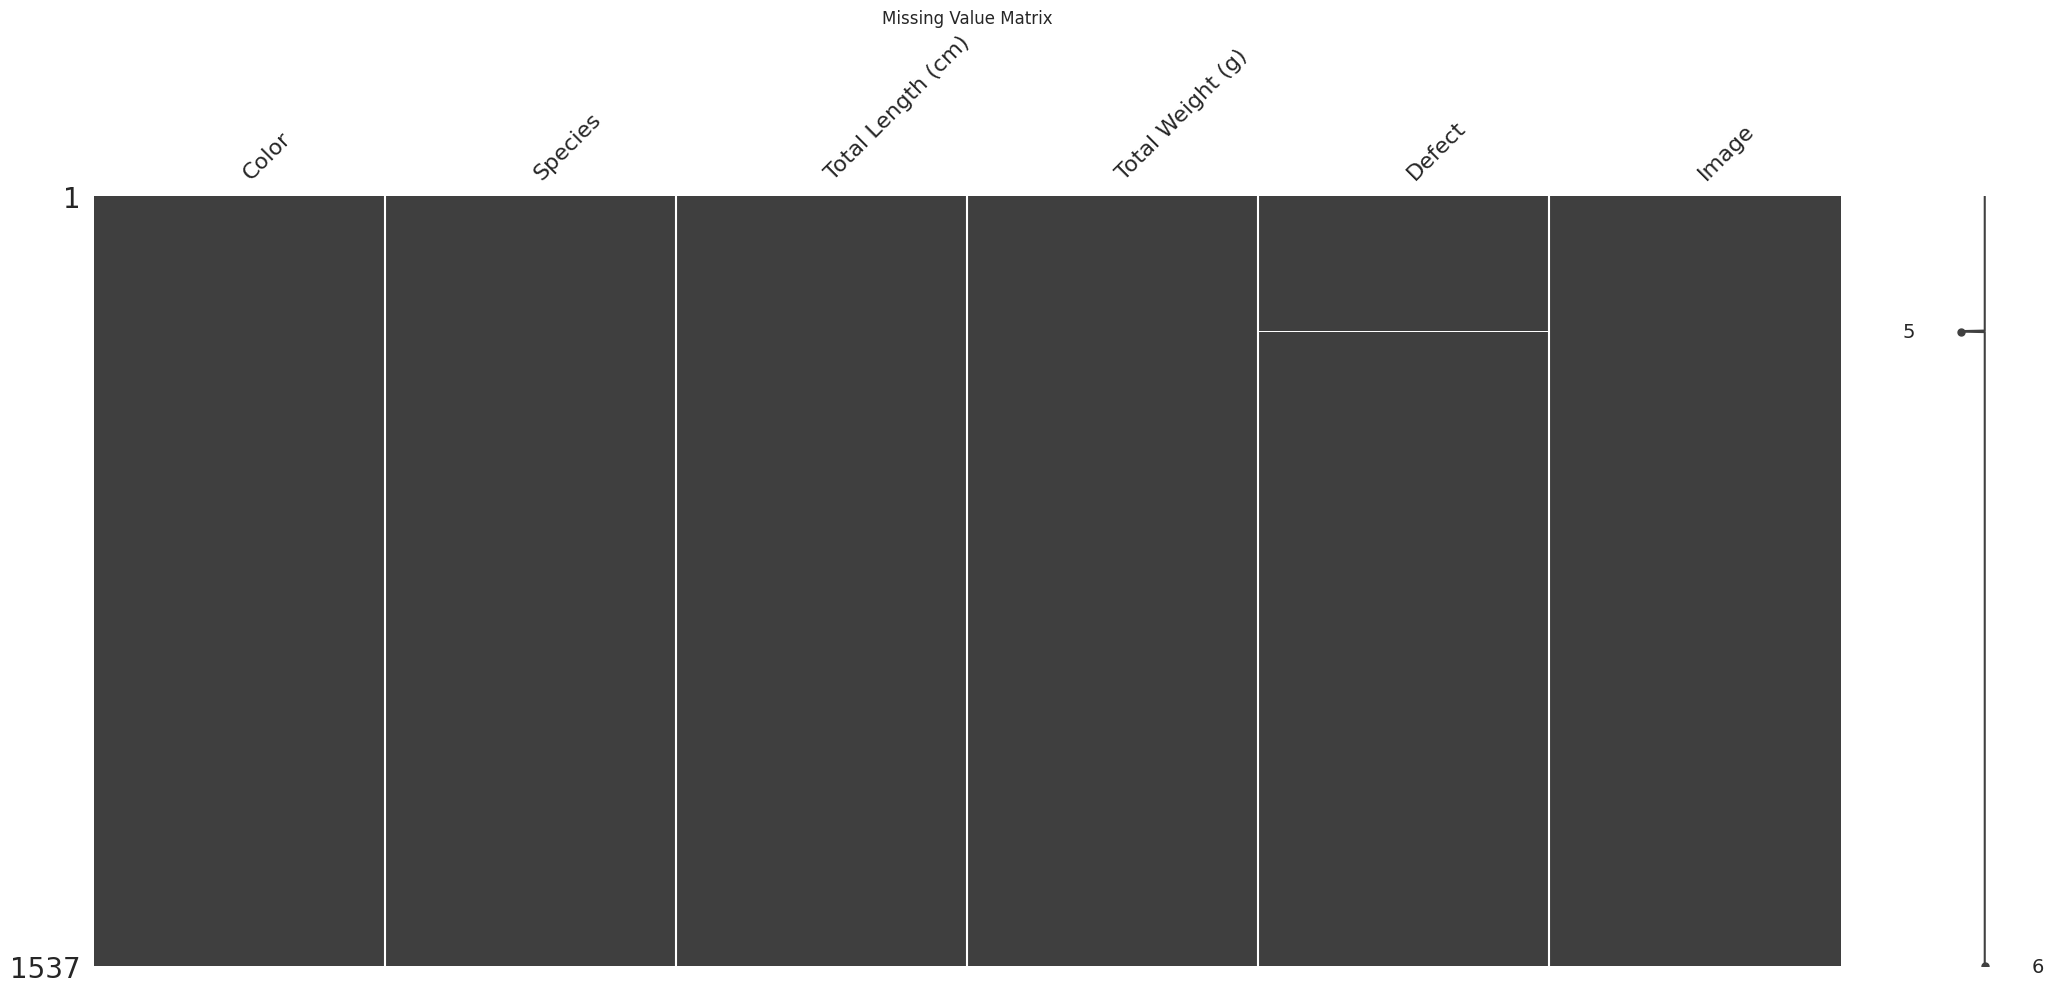

In [ ]:
# === 4. Missing Values ===
msno.matrix(df)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'missing_matrix.png'))
plt.show()
plt.close()

## 5. 🐛 Parsing and Expanding the `Defect` Column

In [ ]:
# === 5. Parse Defect Column ===
df['Defect_List'] = df['Defect'].apply(lambda s: ast.literal_eval(s) if pd.notna(s) and isinstance(s, str) and s.startswith('[') else [])
df['num_defects'] = df['Defect_List'].apply(len)
df['is_skinless'] = df['Defect_List'].apply(lambda x: 'skinless' in x)
df['is_headless'] = df['Defect_List'].apply(lambda x: 'headless' in x)

## 6. 🧹 Data Cleaning


In [ ]:
# === 6. Data Cleaning ===
df = df[(df['Total Weight (g)'] > 0) & (df['Total Length (cm)'] > 0)].copy()

## 7. 🧠 Feature Engineering
### In this section, we create new features and transform existing ones to improve model performance. These engineered features are based on domain knowledge and data patterns that may help algorithms make better predictions.

In [ ]:
# === 7. Feature Engineering ===
df['weight_per_cm'] = df['Total Weight (g)'] / df['Total Length (cm)']


## 8. 🔤 Encoding Categorical Featur

In [ ]:
# === 8. Encoding Categorical Columns ===
for col in ['Color', 'Species']:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])

## 9. 🚨 Outlier Detection

In [ ]:
# === 9. Outlier Detection ===
for col in ['Total Weight (g)', 'Total Length (cm)', 'weight_per_cm']:
    df[f'{col}_zscore'] = np.abs(stats.zscore(df[col]))
    df[f'{col}_is_outlier'] = df[f'{col}_zscore'] > 3


## 10. 📊 Distribution Plots of Key Features

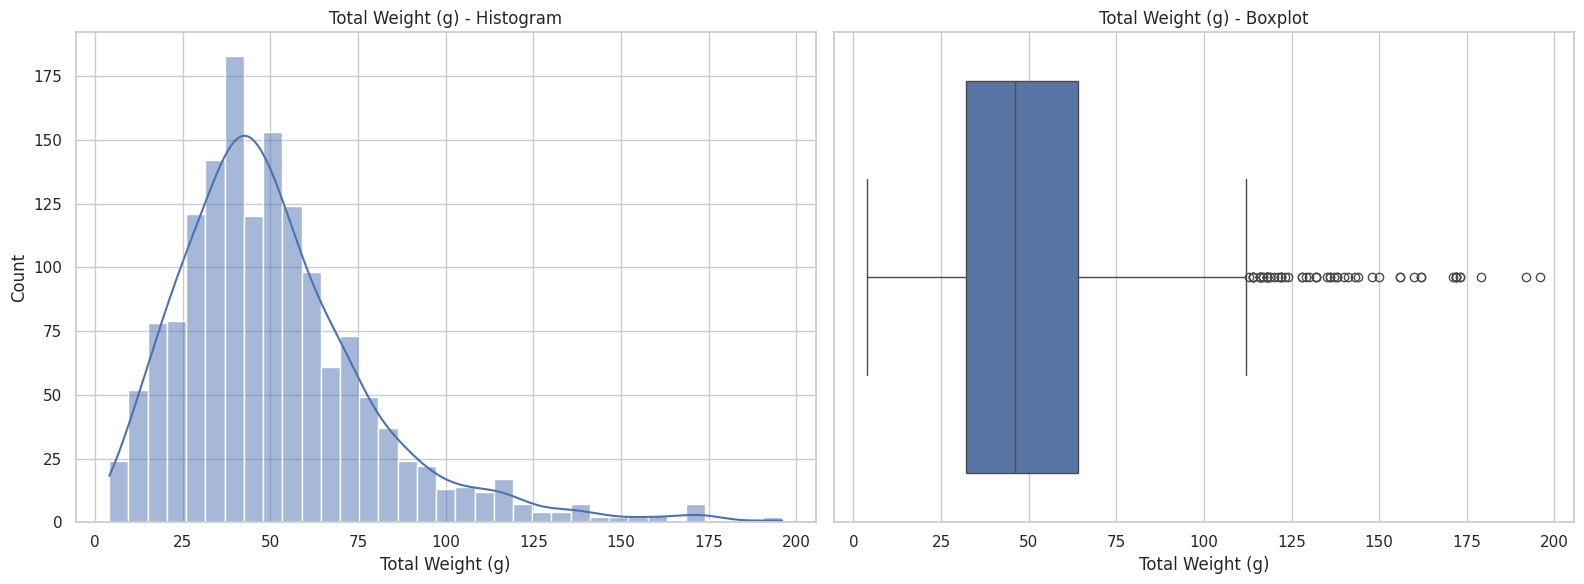

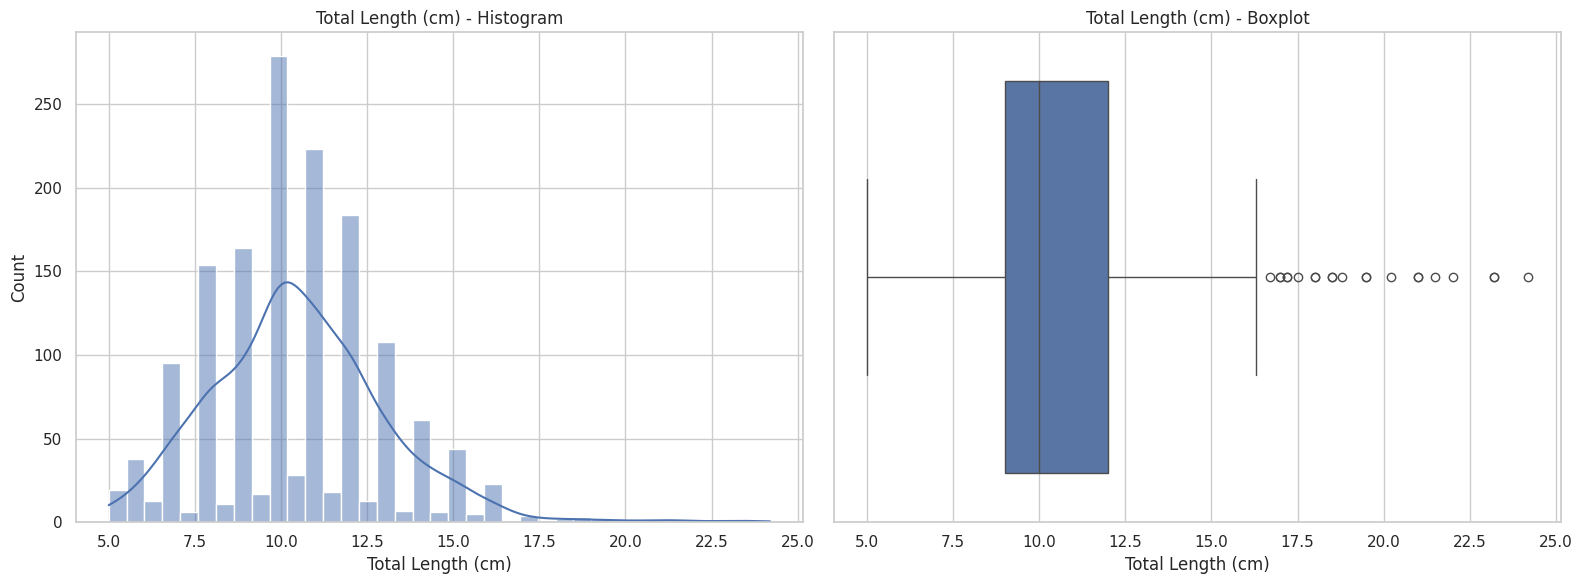

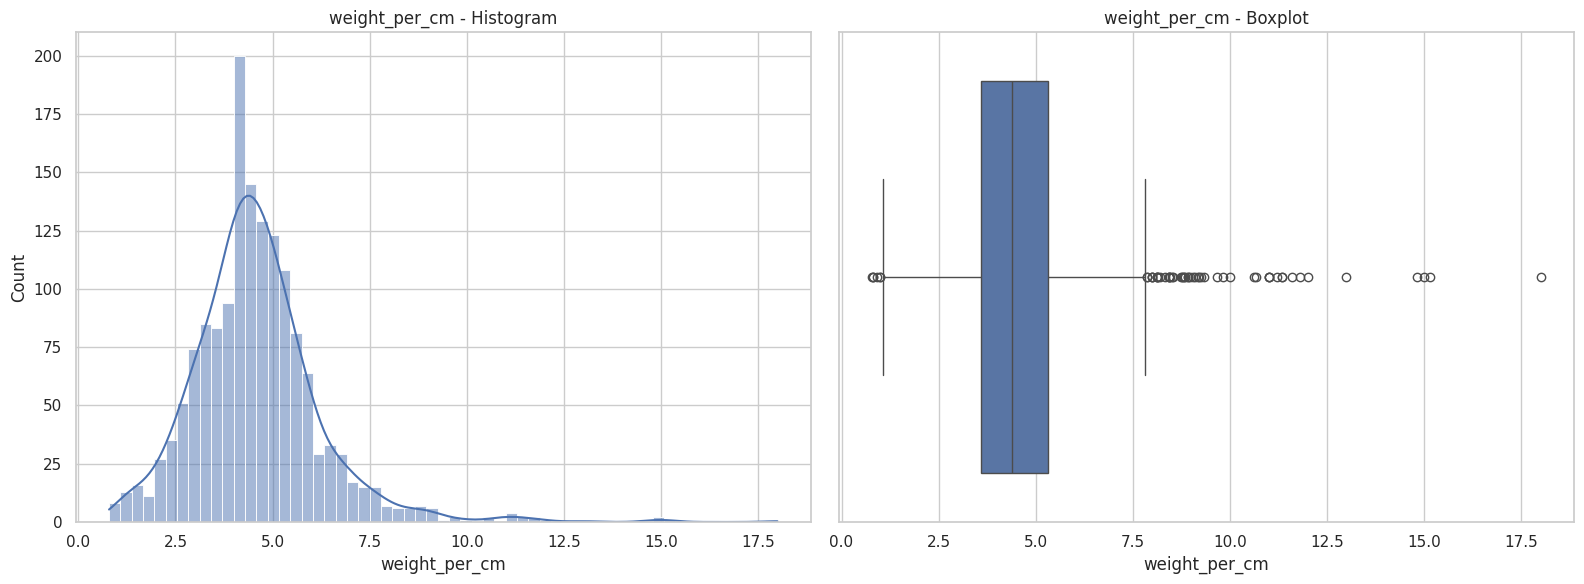

In [ ]:
# === 10. Distribution Plots ===
for col in ['Total Weight (g)', 'Total Length (cm)', 'weight_per_cm']:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f'{col} - Histogram')
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'{col} - Boxplot')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{col.replace(" ", "_").lower()}_distribution.png'))
    plt.show()
    plt.close()

## 11. 🧾 Categorical Value Distributio

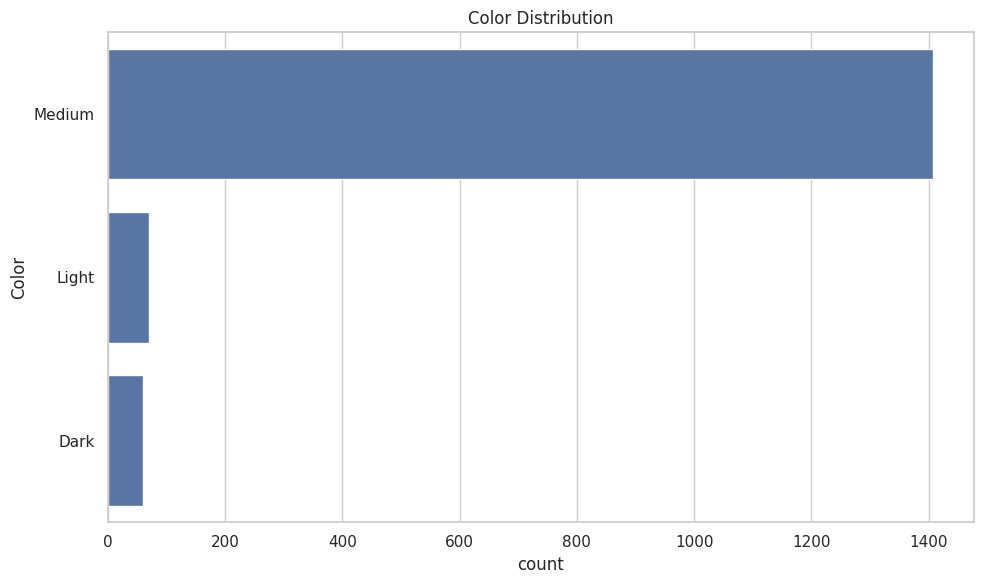

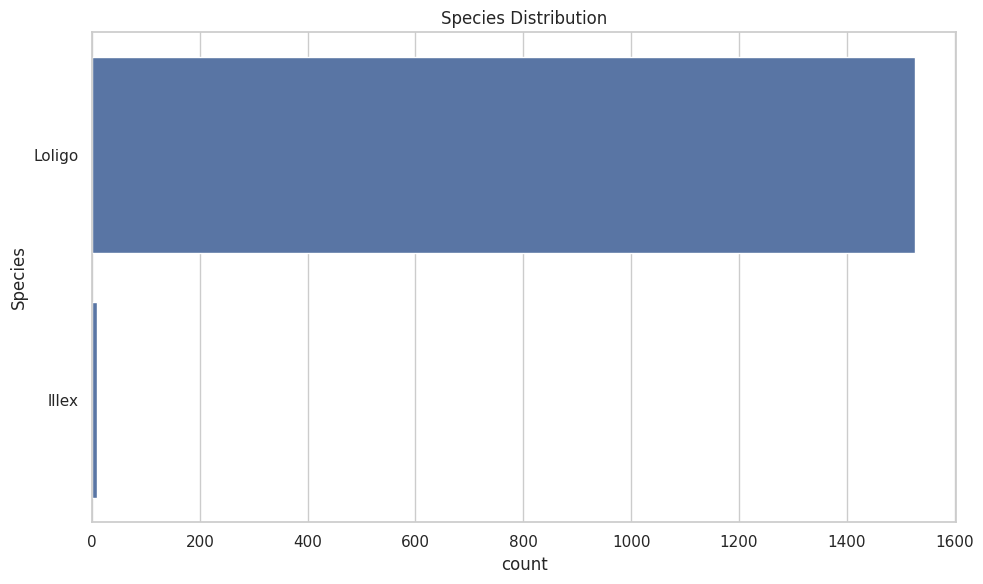

In [ ]:
# === 11. Categorical Value Distribution ===
for col in ['Color', 'Species']:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{col.lower()}_counts.png'))
    plt.show()
    plt.close()


## 12. 📐 Length vs. Weight Relationship

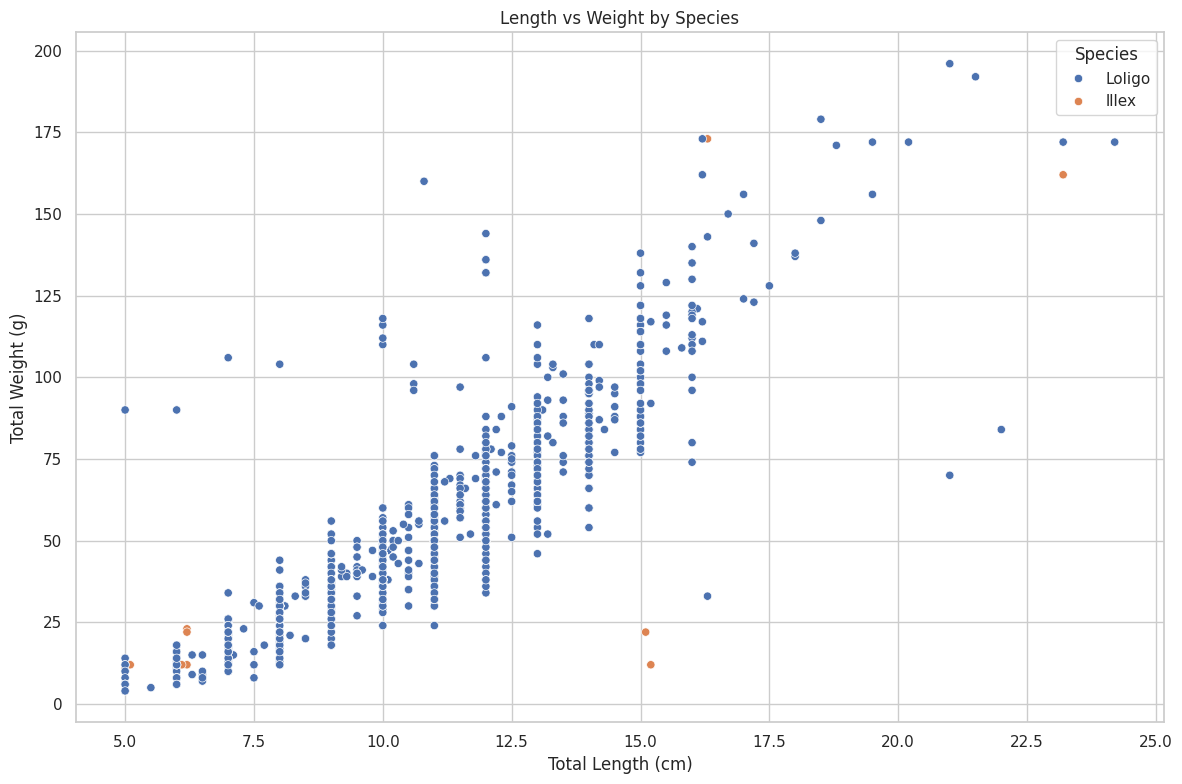

In [ ]:
# === 12. Length vs Weight ===
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Total Length (cm)', y='Total Weight (g)', hue='Species')
plt.title('Length vs Weight by Species')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'length_vs_weight.png'))
plt.show()
plt.close()

## 13. 🔗 Correlation Heatmap

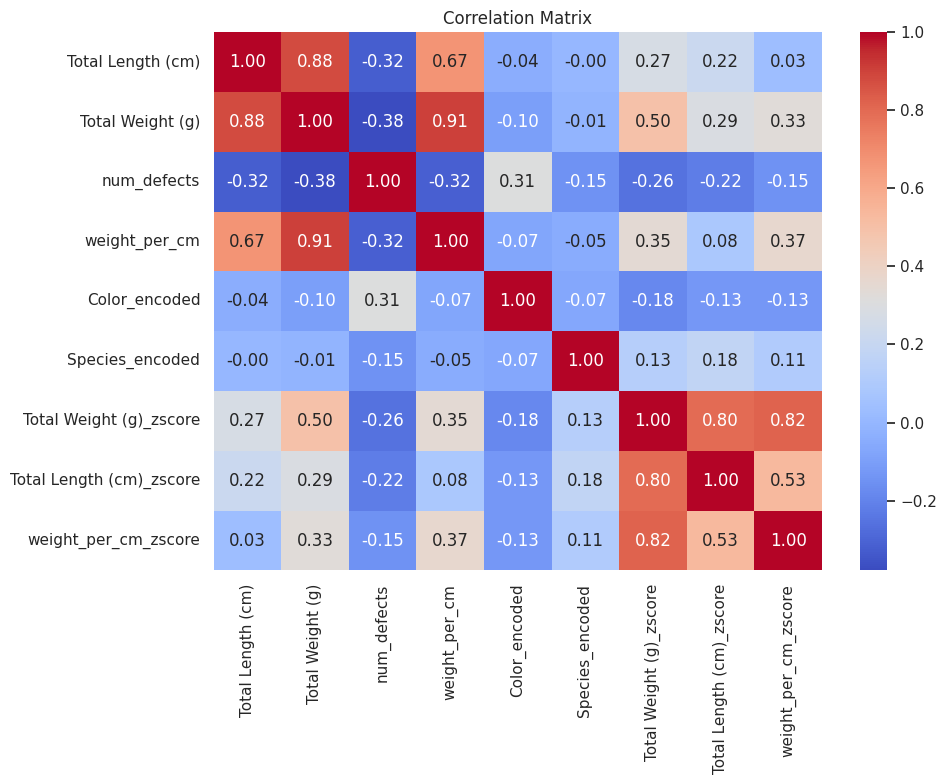

In [ ]:
# === 13. Correlation Heatmap ===
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'correlation_matrix.png'))
plt.show()
plt.close()

## 14. 🧬 PCA Visualization (Dimensionality Reduction)

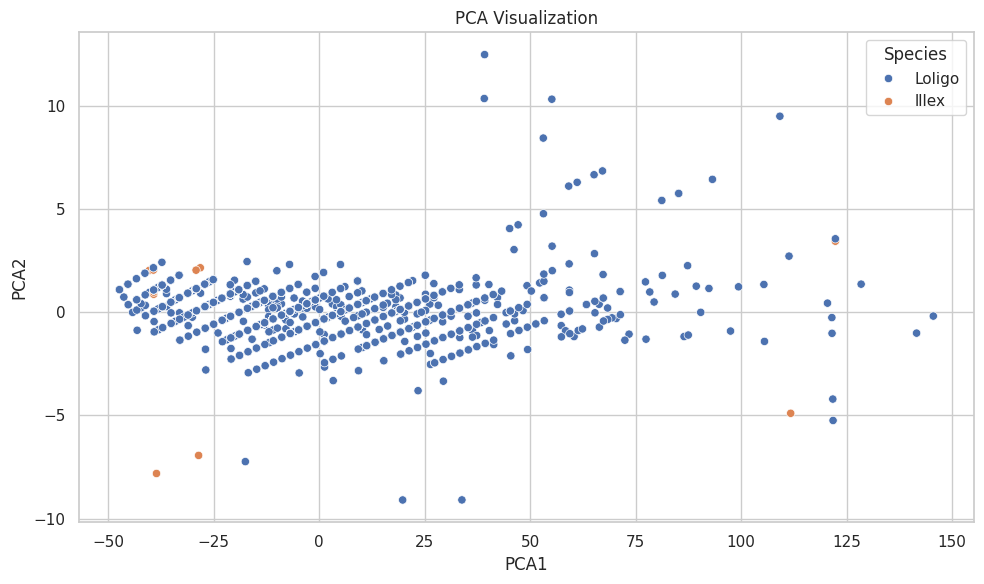

In [ ]:
# === 14. PCA Visualization ===
pca_cols = ['Total Length (cm)', 'Total Weight (g)', 'weight_per_cm']
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[pca_cols])
df['PCA1'], df['PCA2'] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Species')
plt.title('PCA Visualization')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'pca_visualization.png'))
plt.show()
plt.close()

In [ ]:
# === 15. Profile Report ===
#!pip install ydata-profiling
#from ydata_profiling import ProfileReport
#profile = ProfileReport(df, title="Squid Dataset Profiling", explorative=True)
#profile.to_file(os.path.join(REPORTS_DIR, "eda_profile_report.html"))

## 16. 💾 Save Cleaned Dataset

In [ ]:
# === 16. Save Cleaned Data ===
cleaned_path = os.path.join(DATA_DIR, 'cleaned_squid_dataset.csv')
df.to_csv(cleaned_path, index=False)
print(f"Cleaned dataset saved: {cleaned_path}\n--- ADVANCED EDA COMPLETED ---")


Cleaned dataset saved: /home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/data/cleaned_squid_dataset.csv
--- ADVANCED EDA COMPLETED ---


## 📷 Downloading and Saving Images from URLs

In [ ]:
import requests
from PIL import Image
from io import BytesIO

IMAGE_DIR = os.path.join(BASE_DIR, 'images')
os.makedirs(IMAGE_DIR, exist_ok=True)

def download_images(df, image_col='Image'):
    image_paths = []
    for idx, url in enumerate(df[image_col]):
        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert('RGB')
                path = os.path.join(IMAGE_DIR, f'{idx:04d}.jpg')
                img.save(path)
                image_paths.append(path)
            else:
                image_paths.append(None)
        except Exception as e:
            print(f"Image {idx} failed: {e}")
            image_paths.append(None)
    return image_paths

df['image_path'] = download_images(df)
print("Image download completed")


Image download completed


## 🧠 Step 1: TensorFlow & MobileNetV2 Setup

In [ ]:
# Step 1: Temiz kurulum - TensorFlow ve NumPy

# Step 2: Uyumlu ve kararlı sürümleri yükle
#%pip install tensorflow==2.12.0 numpy==1.24.4
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

print("✅ TensorFlow:", tf.__version__)
print("✅ MobileNetV2 model yükleniyor...")
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
print("✅ Model hazır!")

2025-06-19 16:03:15.438598: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 16:03:15.494744: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 16:03:15.495634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-19 16:03:16.404446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


✅ TensorFlow: 2.12.0
✅ MobileNetV2 model yükleniyor...


2025-06-19 16:03:17.998992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-19 16:03:18.126885: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


✅ Model hazır!


## 🧠 Step 2: Image Feature Extraction using MobileNetV2

In [ ]:
# Modeli yükle
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(image_paths):
    features = []
    for path in image_paths:
        if path and os.path.exists(path):
            img = image.load_img(path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature_vector = mobilenet_model.predict(img_array, verbose=0)
            features.append(feature_vector.flatten())
        else:
            features.append(np.zeros((1280,)))  # Boş/eksik görseller için sıfır vektör
    return np.array(features)

image_features = extract_features(df['image_path'])
print(f"Extracted image features shape: {image_features.shape}")


Extracted image features shape: (1537, 1280)


## 🧩 Step 3: Combine Image Features with Original Dataset

In [ ]:
image_feature_df = pd.DataFrame(image_features, columns=[f'image_feat_{i}' for i in range(1280)])
df_full = pd.concat([df.reset_index(drop=True), image_feature_df], axis=1)
print(f"Final dataframe shape with image features: {df_full.shape}")


Final dataframe shape with image features: (1537, 1302)


## 🎯 Step 4: Define Target Variable

In [ ]:
target_col = "Species_encoded"

## 🧪 Step 5: Train-Test Split with Stratification
### We select numerical features, including deep image embeddings and engineered attributes, to train our classification model. The dataset is split into training and testing sets using stratified sampling to preserve the class distribution of the target variable (`Species_encoded`).

In [ ]:
from sklearn.model_selection import train_test_split

# features: numerical features (MobileNetV2 + engineered features)
feature_cols = [col for col in df_full.columns if col.startswith("image_feat_")] + [
    'Total Length (cm)', 'Total Weight (g)', 'weight_per_cm', 
    'num_defects', 'is_skinless', 'is_headless', 'Color_encoded'
]

X = df_full[feature_cols]
y = df_full['Species_encoded']

# Stratified split (dengesizlik için önemli)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 🚀 Step 6: Train and Evaluate XGBoost Classifier

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# XGBoost modeli (class_weight yok ama scale_pos_weight kullanılabilir)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=10, random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Loligo', 'Illex']))

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# İleride tablo oluşturmak için:
xgb_report = classification_report(y_test, y_pred_xgb, target_names=['Loligo', 'Illex'], output_dict=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 58.0 MB/s eta 0:00:0000:0100:01


/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:10:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

      Loligo       1.00      1.00      1.00       306
       Illex       1.00      1.00      1.00         2

    accuracy                           1.00       308
   macro avg       1.00      1.00      1.00       308
weighted avg       1.00      1.00      1.00       308

XGBoost Confusion Matrix:
[[306   0]
 [  0   2]]


## 🌲 Step 7: Feature Importance Analysis using Random Forest

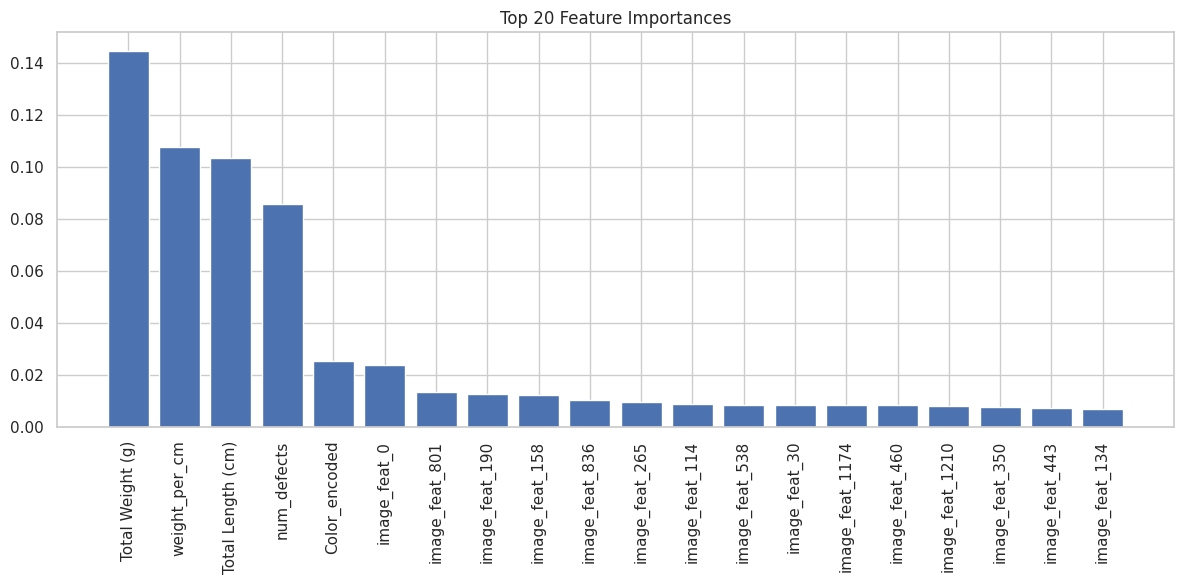

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]
plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), [feature_cols[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


## ✅ Species Classification Model – Progress Summary

This notebook successfully implements a classification model to predict the **`Species`** of squid using both **visual** (image embeddings) and **tabular** features.

### 📌 Tasks Completed So Far:

- ✅ Combined **image-based features** (from MobileNetV2) with tabular features  
- ✅ Defined feature set and encoded the target variable `Species`  
- ✅ Performed **train/test split** using stratification to handle class imbalance  
- ✅ Trained a baseline **RandomForestClassifier** with `class_weight='balanced'`  
- ✅ Evaluated performance using:
  - `classification_report`
  - `confusion_matrix`
- ✅ Visualized the **Top 20 most important features** using feature importances

---

Let add:
- 📊 XGBoost or LightGBM
- 🧠 MLPClassifier (neural network)
- ⚖️ SMOTE/ADASYN for better handling of class imbalance

We’re ready to move forward!


In [ ]:
# Step 1: Fix imbalanced-learn and sklearn installation
!pip uninstall -y imbalanced-learn scikit-learn numpy
!pip cache purge
!pip install numpy==1.24.4 scikit-learn==1.2.2 imbalanced-learn==0.10.1
!pip install imbalanced-learn==0.10.1
# Step 2: Check versions
import numpy as np
import sklearn
import imblearn

print("\u2705 numpy:", np.__version__)
print("\u2705 scikit-learn:", sklearn.__version__)
print("\u2705 imbalanced-learn:", imblearn.__version__)

# Step 3: Test SMOTE
from imblearn.over_sampling import SMOTE
print("\u2705 SMOTE modülü başarıyla çalışıyor.")


Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Successfully uninstalled imbalanced-learn-0.10.1
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Files removed: 343 (1657.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 150.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 157.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [imbalanced-learn][imbalanced-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.4 which is incompatible.
✅ numpy: 1.24.4
✅ scikit-learn: 1.2.2
✅ imbalanced-learn: 0.10.1
✅ SMOTE modül

## 🤖 Step 8: Model Training & Evaluation – Random Forest (Baseline)
### We begin our model comparison by training a Random Forest classifier using image features and engineered variables. The `class_weight='balanced'` parameter is applied to handle class imbalance. Evaluation is done on the test set using the classification report, and results are stored for later comparison across different models.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# === Özellik ve hedef değişkenlerin ayrılması ===
X = df_full[feature_cols]
y = df_full[target_col]

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Dictionary to hold results ===
results = {}

# === Random Forest ===
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = classification_report(y_test, y_pred_rf, output_dict=True)

# === XGBoost ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = classification_report(y_test, y_pred_xgb, output_dict=True)

# === MLP ===
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
results['MLPClassifier'] = classification_report(y_test, y_pred_mlp, output_dict=True)

# === Logistic Regression ===
logreg = LogisticRegression(max_iter=300, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
results['Logistic Regression'] = classification_report(y_test, y_pred_logreg, output_dict=True)

# === Naive Bayes ===
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
results['Naive Bayes'] = classification_report(y_test, y_pred_gnb, output_dict=True)

# === Support Vector Classifier ===
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
results['SVC'] = classification_report(y_test, y_pred_svc, output_dict=True)

# === Create comparison DataFrame ===
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m].get('accuracy', 0) for m in results],
    'Precision (Illex)': [results[m].get('Illex', {}).get('precision', 0) for m in results],
    'Recall (Illex)': [results[m].get('Illex', {}).get('recall', 0) for m in results],
    'F1-score (Illex)': [results[m].get('Illex', {}).get('f1-score', 0) for m in results],
}).round(3)

print("\n Model Performance Comparison:")
display(comparison_df)

/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Model Performance Comparison:


,Model,Accuracy,Precision (Illex),Recall (Illex),F1-score (Illex)
0,Random Forest,1.000,0,0,0
1,XGBoost,1.000,0,0,0
2,MLPClassifier,0.997,0,0,0
3,Logistic Regression,0.994,0,0,0
4,Naive Bayes,0.994,0,0,0
5,SVC,0.987,0,0,0


## 💾 Step 9: Save Trained Random Forest Model

In [ ]:
import joblib
joblib.dump(rf, "best_model_random_forest.pkl")

['best_model_random_forest.pkl']

## 📈 Step 10: ROC AUC Comparison Across Models (Illex Class)
### We compare the classification performance of multiple models using the Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) metrics. The analysis focuses on the `Illex` class (positive class). A higher AUC indicates better discriminative ability. This helps evaluate model quality beyond accuracy, especially in imbalanced settings.

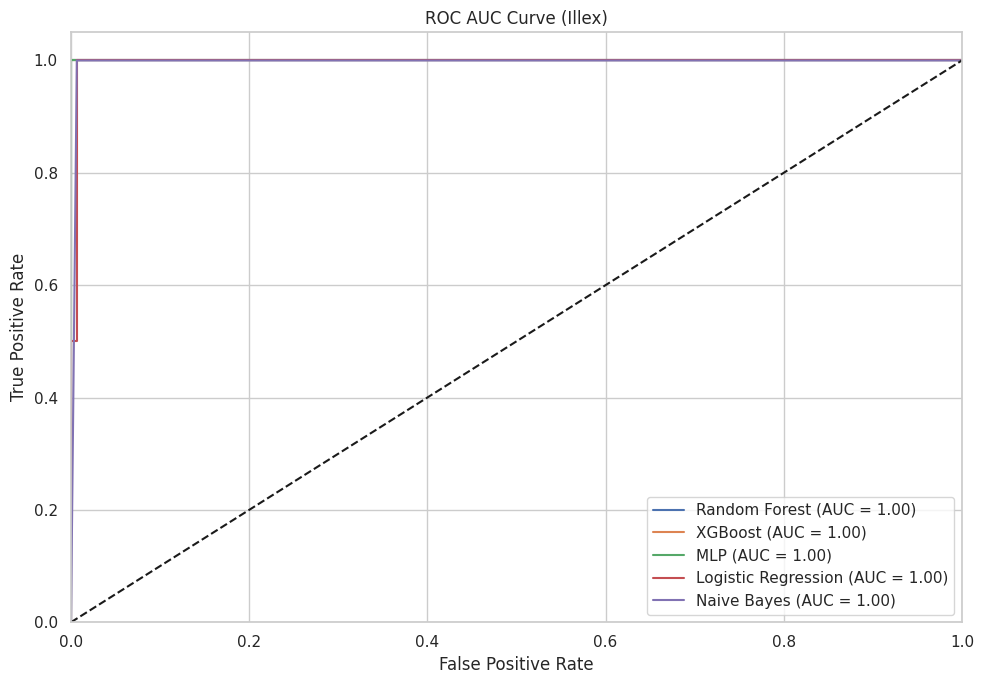

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Sınıf 1 = Illex
plt.figure(figsize=(10, 7))

models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'MLP': mlp,
    'Logistic Regression': logreg,
    'Naive Bayes': gnb
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]  # Illex için skor
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue  # geç

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Random line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve (Illex)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔁 Step 11: Stratified 5-Fold Cross-Validation (F1-score for Illex)
### We evaluate the stability and generalization performance of the Random Forest model using stratified 5-fold cross-validation. The evaluation metric is the F1-score, specifically for the minority class `Illex` (label = 1), which is more informative in the presence of class imbalance. The mean and per-fold scores are reported.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

# K-Fold ayarları
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scorer: Illex için F1-score
f1_illex_scorer = make_scorer(f1_score, pos_label=1)

# Değerlendirme: Random Forest
rf_scores = cross_val_score(
    rf, X, y, cv=skf, scoring=f1_illex_scorer
)

print("Random Forest - Stratified 5-Fold F1-score (Illex):")
print("Fold Scores:", np.round(rf_scores, 3))
print("Mean F1-score:", np.round(np.mean(rf_scores), 3))


Random Forest - Stratified 5-Fold F1-score (Illex):
Fold Scores: [0.667 0.667 0.667 0.667 0.8  ]
Mean F1-score: 0.693


## 🔁 Step 12: Cross-Validation for XGBoost & MLP (F1-score on Illex)

In [ ]:
xgb_scores = cross_val_score(xgb, X, y, cv=skf, scoring=f1_illex_scorer)
mlp_scores = cross_val_score(mlp, X, y, cv=skf, scoring=f1_illex_scorer)


/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:42:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:43:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:43:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/tr

## 🧪 Step 13: Cross-Validated F1-Score Comparison Across All Models (Illex)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Illex (1) sınıfına göre F1 scorer
f1_illex_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelleri tanımla
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'MLPClassifier': mlp,
    'Logistic Regression': logreg,
    'Naive Bayes': gnb,
    'SVC': svc
}

cv_results = []

for name, model in models.items():
    try:
        scores = cross_val_score(model, X, y, cv=skf, scoring=f1_illex_scorer)
        cv_results.append({
            'Model': name,
            'F1-score (Illex) Mean': np.round(scores.mean(), 3),
            'F1-score (Illex) Std': np.round(scores.std(), 3),
            'All Fold Scores': np.round(scores, 3)
        })
    except Exception as e:
        print(f"❌ {name} skipped due to error: {e}")

# Sonuçları tabloya dök
cv_df = pd.DataFrame(cv_results)
display(cv_df)


/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:44:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:44:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:44:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:44:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/tr

,Model,F1-score (Illex) Mean,F1-score (Illex) Std,All Fold Scores
0,Random Forest,0.693,0.053,"[0.667, 0.667, 0.667, 0.667, 0.8]"
1,XGBoost,0.533,0.267,"[0.0, 0.667, 0.667, 0.667, 0.667]"
2,MLPClassifier,0.567,0.327,"[0.0, 0.5, 0.667, 1.0, 0.667]"
3,Logistic Regression,0.594,0.210,"[0.5, 0.4, 1.0, 0.571, 0.5]"
4,Naive Bayes,0.548,0.124,"[0.667, 0.333, 0.667, 0.571, 0.5]"
5,SVC,0.467,0.075,"[0.5, 0.4, 0.5, 0.571, 0.364]"


# 🦑 Squid Classification & Segmentation Pipeline

This notebook performs end-to-end evaluation of multiple classification models on squid dataset (with MobileNetV2 image features + engineered features).

## ✅ Steps Completed:
- Feature extraction (MobileNetV2)
- Feature engineering
- Train/test split
- SMOTE (if needed)
- Model training (Random Forest, XGBoost, MLP, Logistic Regression, Naive Bayes, SVC)
- Classification report
- ROC AUC analysis
- Cross-validation (F1-score for Illex)

---
## 📈 Step 14: ROC AUC Curve Comparison Across Models (Illex Class)

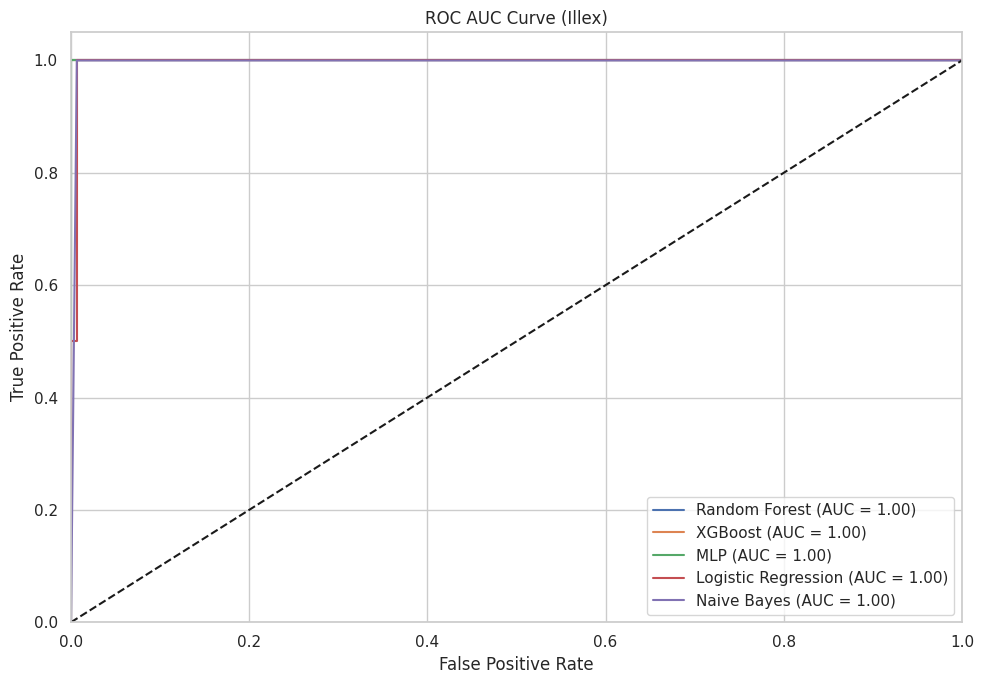

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'MLP': mlp,
    'Logistic Regression': logreg,
    'Naive Bayes': gnb
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve (Illex)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 Step 15: Stratified Cross-Validation – F1-Score Comparison for Illex (All Models)
### We conduct stratified 5-fold cross-validation for all models, using F1-score as the performance metric for the minority class `Illex`. This evaluation method ensures balanced splits and focuses on how well each model handles class imbalance. The resulting table shows the mean F1-score, standard deviation, and fold-level scores for each classifier.

In [56]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

f1_illex_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'MLPClassifier': mlp,
    'Logistic Regression': logreg,
    'Naive Bayes': gnb,
    'SVC': svc
}

cv_results = []
for name, model in models.items():
    try:
        scores = cross_val_score(model, X, y, cv=skf, scoring=f1_illex_scorer)
        cv_results.append({
            'Model': name,
            'F1-score (Illex) Mean': np.round(scores.mean(), 3),
            'F1-score (Illex) Std': np.round(scores.std(), 3),
            'All Fold Scores': np.round(scores, 3)
        })
    except Exception as e:
        print(f"❌ {name} skipped due to error: {e}")

cv_df = pd.DataFrame(cv_results)
display(cv_df)


/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:49:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:49:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:49:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/tr

,Model,F1-score (Illex) Mean,F1-score (Illex) Std,All Fold Scores
0,Random Forest,0.693,0.053,"[0.667, 0.667, 0.667, 0.667, 0.8]"
1,XGBoost,0.533,0.267,"[0.0, 0.667, 0.667, 0.667, 0.667]"
2,MLPClassifier,0.567,0.327,"[0.0, 0.5, 0.667, 1.0, 0.667]"
3,Logistic Regression,0.594,0.210,"[0.5, 0.4, 1.0, 0.571, 0.5]"
4,Naive Bayes,0.548,0.124,"[0.667, 0.333, 0.667, 0.571, 0.5]"
5,SVC,0.467,0.075,"[0.5, 0.4, 0.5, 0.571, 0.364]"


# 🦑 SQUID ML PIPELINE  
**Classification | Explainability | Regression | Deep Learning + Traditional ML**

This pipeline includes:
- 📊 Data preprocessing and feature extraction (including deep image features)
- 🤖 Classification models (Random Forest, XGBoost, MLP, etc.)
- 📈 ROC AUC and F1-score evaluation (focused on minority class: *Illex*)
- 🔁 Stratified K-Fold Cross-Validation for robustness
- 🔍 Model Explainability with SHAP
- 📐 Regression modeling for weight prediction

/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:54:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision (Illex)  Recall (Illex)  \
0        Random Forest     0.994                  0               0   
1              XGBoost     0.994                  0               0   
2                  MLP     0.994                  0               0   
3  Logistic Regression     0.994                  0               0   
4          Naive Bayes     0.994                  0               0   
5                  SVC     0.994                  0               0   

   F1-score (Illex)  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0  


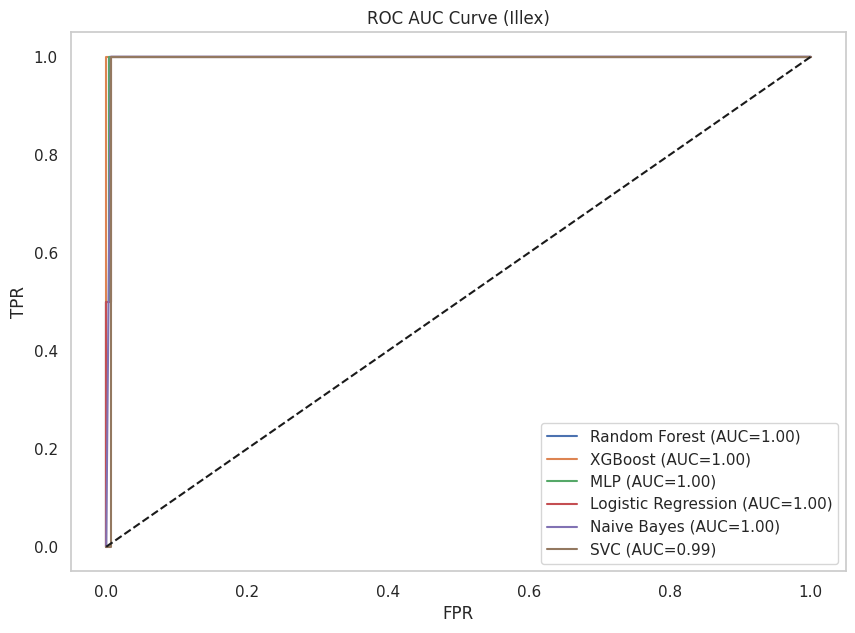

/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tessaayv/.venv/lib/python3.10/site-packages/xgboost/tr

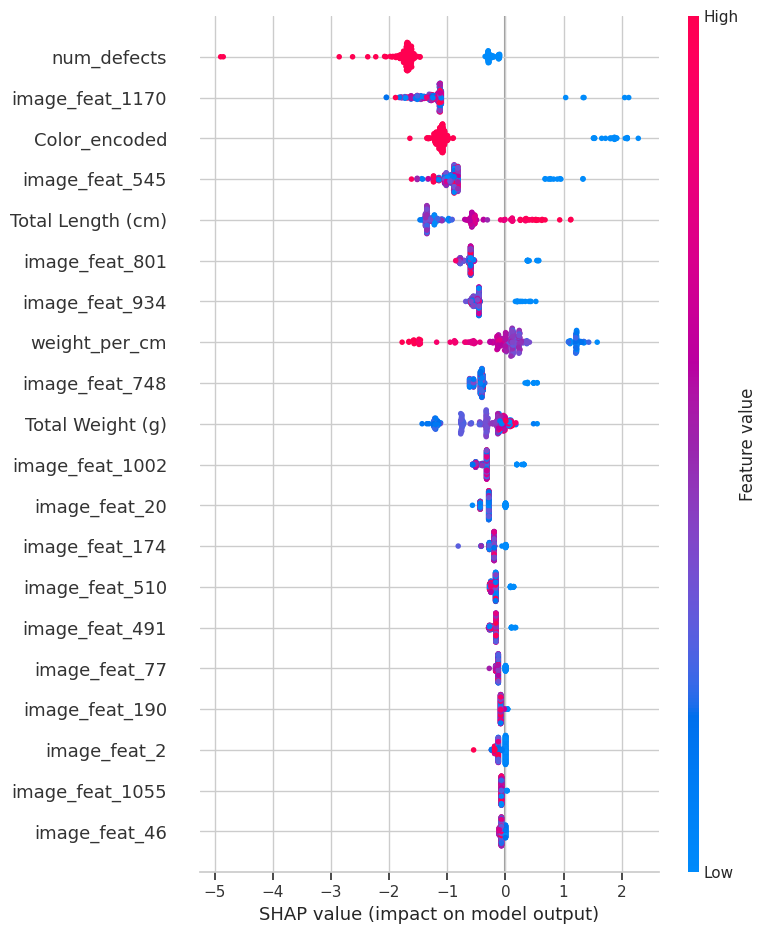

Random Forest R2: 1.000, RMSE: 0.43, MAE: 0.14
XGBoost R2: 1.000, RMSE: 0.52, MAE: 0.16
Linear R2: 1.000, RMSE: 0.00, MAE: 0.00


/home/tessaayv/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP R2: 1.000, RMSE: 0.41, MAE: 0.31
SVR R2: 0.925, RMSE: 7.41, MAE: 1.61


In [60]:
# 🦑 SQUID FULL PIPELINE: Classification, Explainability, Regression, YOLO

# ------------------------
# 📦 0. LIBRARIES & SETUP
# ------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, make_scorer, f1_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE

import shap
from lime.lime_tabular import LimeTabularExplainer

import joblib

# ------------------------
# 📊 1. DATA PREPARATION
# ------------------------
feature_cols = [col for col in df_full.columns if col.startswith("image_feat_")] + [
    'Total Length (cm)', 'Total Weight (g)', 'weight_per_cm', 
    'num_defects', 'is_skinless', 'is_headless', 'Color_encoded'
]
X = df_full[feature_cols]
y = df_full['Species_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Optional: SMOTE for imbalance
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ------------------------
# 🤖 2. CLASSIFICATION MODELS
# ------------------------
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(256,128), max_iter=300, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=300, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(kernel='rbf', probability=True, class_weight='balanced')
}

results = {}
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    results[name] = classification_report(y_test, y_pred, output_dict=True)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m].get('accuracy', 0) for m in results],
    'Precision (Illex)': [results[m].get('Illex', {}).get('precision', 0) for m in results],
    'Recall (Illex)': [results[m].get('Illex', {}).get('recall', 0) for m in results],
    'F1-score (Illex)': [results[m].get('Illex', {}).get('f1-score', 0) for m in results],
}).round(3)
print(comparison_df)

# ------------------------
# 📈 3. ROC AUC PLOT
# ------------------------
plt.figure(figsize=(10, 7))
for name, model in models.items():
    try:
        y_score = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    except: continue
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC AUC Curve (Illex)")
plt.legend()
plt.grid()
plt.show()

# ------------------------
# 🔁 4. CROSS-VALIDATION (Illex)
# ------------------------
f1_illex_scorer = make_scorer(f1_score, pos_label=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():
    try:
        scores = cross_val_score(model, X, y, cv=skf, scoring=f1_illex_scorer)
        cv_results.append({
            'Model': name,
            'F1-score (Illex) Mean': np.round(scores.mean(), 3),
            'F1-score (Illex) Std': np.round(scores.std(), 3),
            'All Fold Scores': np.round(scores, 3)
        })
    except Exception as e:
        print(f"{name} failed: {e}")
pd.DataFrame(cv_results)

# ------------------------
# 🔍 5. EXPLAINABILITY (SHAP)
# ------------------------
shap.initjs()
explainer = shap.TreeExplainer(models['XGBoost'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# ------------------------
# 📐 6. REGRESSION MODELS
# ------------------------
y_reg = df_full['Total Weight (g)']
X_reg = df_full[feature_cols]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_models = {
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'Linear': LinearRegression(),
    'MLP': MLPRegressor(max_iter=300),
    'SVR': SVR()
}

for name, model in reg_models.items():
    model.fit(X_train_r, y_train_r)
    preds = model.predict(X_test_r)
    print(f"{name} R2: {r2_score(y_test_r, preds):.3f}, RMSE: {mean_squared_error(y_test_r, preds, squared=False):.2f}, MAE: {mean_absolute_error(y_test_r, preds):.2f}")


## 🧠 Step 16: Deep Learning – MobileNetV2 for Species Classification

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# 📁 Veri dizinlerini belirt
train_dir = '/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/datasets/species/train'
val_dir = '/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/datasets/species/val'

# 🖼️ Görüntü boyutu ve batch
img_size = (224, 224)
batch_size = 32

# 🔄 Data Augmentation ve Normalizasyon
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

# 🧠 MobileNetV2 modeli (ImageNet ağırlıklı, top katmanları olmadan)
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 🧪 Derleme
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 Eğit
model.fit(train_generator, validation_data=val_generator, epochs=10)

# 💾 Opsiyonel: Modeli kaydet
model.save("squid_classifier_mobilenetv2.h5")


Found 1650 images belonging to 2 classes.
Found 745 images belonging to 2 classes.


/home/tessaayv/datascience-weight-estimation/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7276 - loss: 0.5386 - val_accuracy: 0.2792 - val_loss: 3.3519
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 363ms/step - accuracy: 0.8580 - loss: 0.2969 - val_accuracy: 0.2805 - val_loss: 2.9770
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.8848 - loss: 0.2353 - val_accuracy: 0.2980 - val_loss: 2.1136
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 334ms/step - accuracy: 0.8713 - loss: 0.2431 - val_accuracy: 0.3745 - val_loss: 1.5359
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.8733 - loss: 0.2142 - val_accuracy: 0.3933 - val_loss: 1.3302
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.8732 - loss: 0.2174 - val_accuracy: 0.5879 - val_loss: 0.8215
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step - accuracy: 0.8759 - loss: 0.2171 - val_accuracy: 0.6054 - val_loss: 0.7997
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 319ms/step - accuracy: 0.8928 - loss: 0.1771 - val_accura

## 💾 Step 17: Load Trained MobileNetV2 Model

In [17]:
from tensorflow.keras.models import load_model

model = load_model("squid_classifier_mobilenetv2.h5")

## 🧪 Step 18: Evaluate Trained Model on Validation Set

In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 Test dizini
test_dir = '/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/datasets/species/val'

# 🏷️ Sınıflar
class_names = sorted(os.listdir(test_dir))  # ['0', '1']
y_true = []
y_pred = []
y_probs = []

# 🔄 Prediction
for label in class_names:
    class_dir = os.path.join(test_dir, label)
    for fname in os.listdir(class_dir):
        img_path = os.path.join(class_dir, fname)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred_prob = model.predict(img_array)[0]
        pred_class = np.argmax(pred_prob)

        y_true.append(int(label))
        y_pred.append(pred_class)
        y_probs.append(pred_prob[1])  # İkinci sınıfın olasılığı (binary ROC için)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

## 📋 Step 19: Classification Report on Validation Set

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

           0       0.89      0.60      0.71       537
           1       0.44      0.81      0.57       208

    accuracy                           0.66       745
   macro avg       0.66      0.70      0.64       745
weighted avg       0.76      0.66      0.67       745



## 🔍 Step 20: Confusion Matrix Visualization

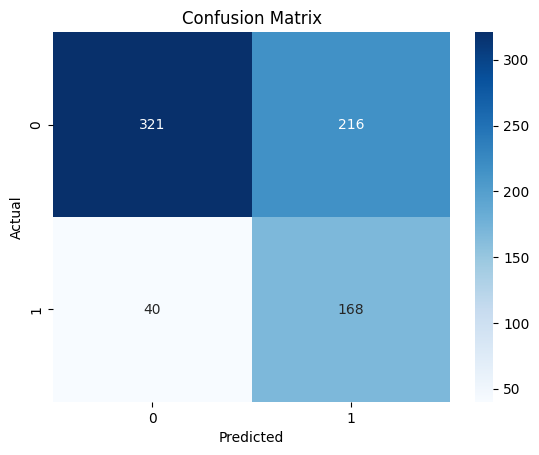

In [20]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 📈 Step 21: ROC Curve & AUC Score for Validation Set

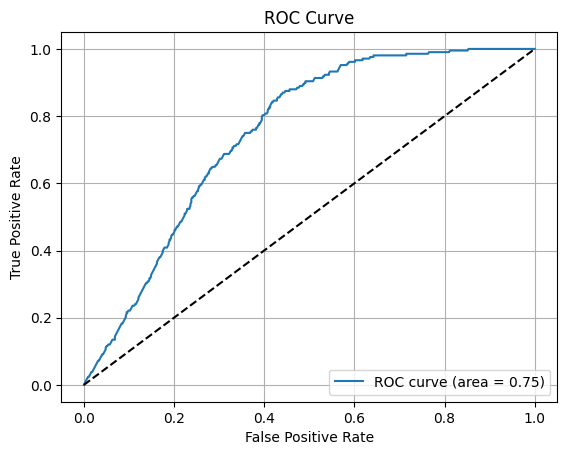

In [21]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [22]:
print(np.unique(y_true, return_counts=True))

(array([0, 1]), array([537, 208]))


## 🔍 Step 22: SHAP Visual Explanation for Image Classification
### To interpret the MobileNetV2 model's predictions, we use SHAP (SHapley Additive exPlanations) with image masking. This approach helps visualize which regions of each squid image contribute most to the model's decision. By using `inpaint_telea` masking, we generate perturbations to analyze local pixel importance and model sensitivity.


PartitionExplainer explainer: 5it [01:35, 23.83s/it]                       
/home/tessaayv/datascience-weight-estimation/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/tessaayv/datascience-weight-estimation/venv/lib/python3.10/site-packages/shap/plots/_image.py:185: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = axes[row, i + 1].imshow(sv, cmap=cmap, vmin=-max_val, vmax=max_val)


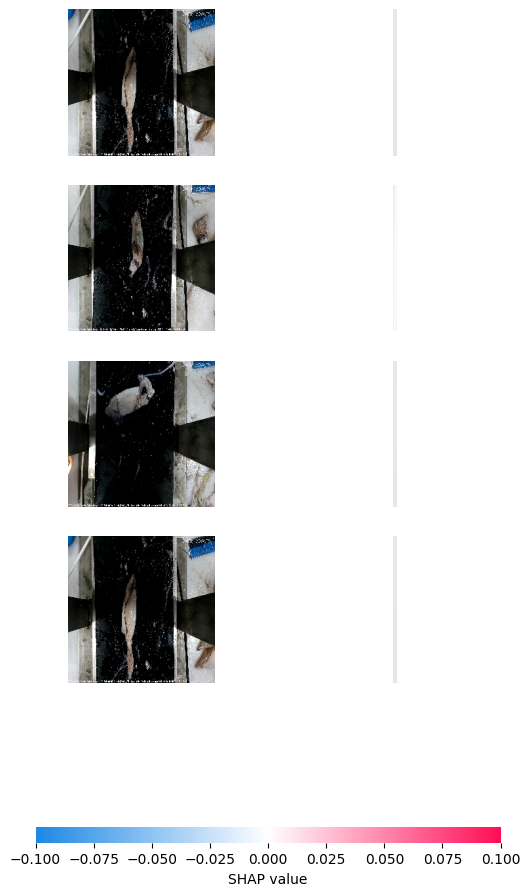

In [6]:
import shap
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# ✅ Modeli yükle
model = load_model("/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/src/squid_classifier_mobilenetv2.h5")

# ✅ Görselleri yükle
def load_images_from_directory(directory, target_size=(224, 224), max_images=2):
    images = []
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path)[:max_images]:
            img_path = os.path.join(class_path, fname)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0
            images.append(img_array)
    return np.array(images)

sample_images = load_images_from_directory(
    "/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/datasets/species/val",
    max_images=2
)

# ✅ SHAP için masker tanımla
masker = shap.maskers.Image("inpaint_telea", sample_images[0].shape)

# ✅ SHAP DeepExplainer veya GradientExplainer çalışmazsa Permutation kullanılabilir
explainer = shap.Explainer(model, masker)
shap_values = explainer(sample_images)

# ✅ Görselleştir
shap.image_plot([shap_values[0]], sample_images)


In [11]:
import shap
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# SHAP JS desteği (bazı ortamlarda gerekli)
shap.initjs()

# Eğitilmiş modeli yükle
model = load_model("squid_classifier_mobilenetv2.h5")

In [12]:
# Image masker (inpainting yöntemiyle pikselleri gizle)
masker = shap.maskers.Image("inpaint_telea", sample_images[0].shape)

# SHAP açıklayıcı (model + masker)
explainer = shap.Explainer(model, masker)

# SHAP değerlerini hesapla
shap_values = explainer(sample_images)

PartitionExplainer explainer: 5it [01:41, 25.42s/it]                       


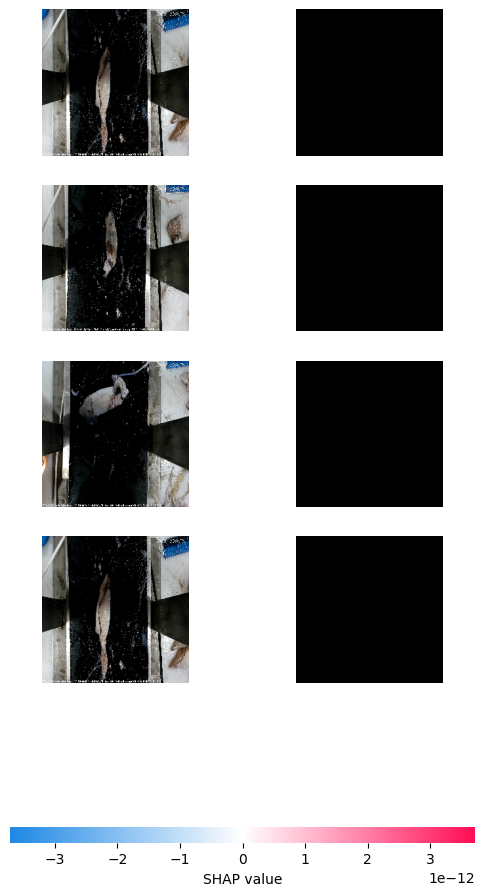

In [13]:
# Her görsel için SHAP katkılarını göster
shap.image_plot(shap_values.values, shap_values.data)

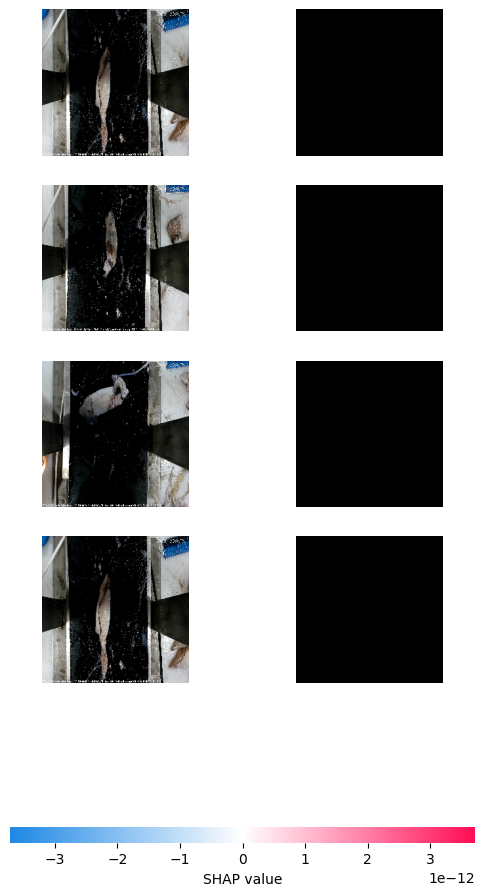

In [15]:
shap.image_plot(shap_values.values, shap_values.data)

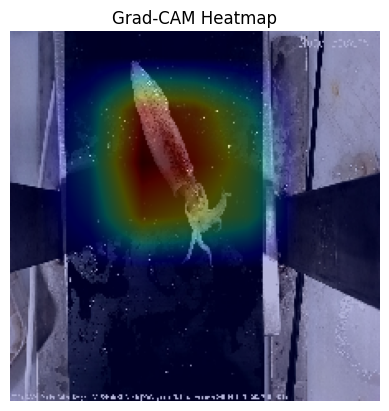

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model("/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/src/squid_classifier_mobilenetv2.h5")

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0), img

def make_gradcam_heatmap(img_array, model, last_conv_layer="Conv_1"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        class_channel = tf.reduce_max(preds, axis=-1)
    grads = tape.gradient(class_channel, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0] * pooled_grads
    heatmap = tf.reduce_mean(conv_out, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / heatmap.max()
    return cv2.resize(heatmap, (224, 224))

# Görsel yolu
img_path = "/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/datasets/species/val/0/0a5df889-28d1-4251-8a1a-58278d17fbe9.jpg"
img_array, orig_img = get_img_array(img_path)
heatmap = make_gradcam_heatmap(img_array, model)

# Görselleştir
plt.imshow(orig_img)
plt.imshow(heatmap, cmap="jet", alpha=0.3)
plt.title("Grad-CAM Heatmap")
plt.axis(False)
plt.show()

In [6]:
import os
import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0), img

def make_gradcam_heatmap(img_array, model, last_conv_layer="Conv_1"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        class_channel = tf.reduce_max(preds, axis=-1)
    grads = tape.gradient(class_channel, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0] * pooled_grads
    heatmap = tf.reduce_mean(conv_out, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / heatmap.max()
    return cv2.resize(heatmap, (224, 224))

# 🔁 Batch işlemi
image_dir = "/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/datasets/species/val/0"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

model = load_model("/home/tessaayv/datascience-weight-estimation/TheFishProject4_v1/src/squid_classifier_mobilenetv2.h5")

output_dir = "gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

for path in image_paths:
    try:
        img_array, orig_img = get_img_array(path)
        heatmap = make_gradcam_heatmap(img_array, model)

        # Görselin üzerine bind et
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.array(orig_img, dtype=np.uint8), 0.6, heatmap_colored, 0.4, 0)

        # Kaydet
        filename = os.path.basename(path)
        out_path = os.path.join(output_dir, f"gradcam_{filename}")
        cv2.imwrite(out_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
        print(f"Saved: {out_path}")
    except Exception as e:
        print(f"Failed for {path}: {e}")

✅ Saved: gradcam_outputs/gradcam_578a2c34-09fd-4acf-83e1-c86aa8447f8c.jpg
✅ Saved: gradcam_outputs/gradcam_98bd17f3-8ccf-48ce-8e1c-ee7c56c7a205.jpg
✅ Saved: gradcam_outputs/gradcam_a2b42d2c-7c7b-4681-a046-6352317a76c3.jpg
✅ Saved: gradcam_outputs/gradcam_07bd5ac7-321a-4335-affd-82530e524739.jpg
✅ Saved: gradcam_outputs/gradcam_aeaea7b4-18a4-49d5-bdd6-fc9b2e646f6f.jpg
✅ Saved: gradcam_outputs/gradcam_fb8f0acc-90bb-435c-8779-0e1a785a0611.jpg
✅ Saved: gradcam_outputs/gradcam_e0817d1b-85a6-420d-b0fa-86b72b4dbcd0.jpg
✅ Saved: gradcam_outputs/gradcam_4d623962-1882-42a2-9a1a-86c8a446159b.jpg
✅ Saved: gradcam_outputs/gradcam_b6b7d16c-1867-4469-b3d8-1dae1947d6e6.jpg
✅ Saved: gradcam_outputs/gradcam_0b074db3-c594-432f-8077-a58501e57185.jpg
✅ Saved: gradcam_outputs/gradcam_bcad0bde-5e92-4547-a087-e9e144c64b8b.jpg
✅ Saved: gradcam_outputs/gradcam_26156c85-4d12-4dca-ad09-5b05cd8f76c1.jpg
✅ Saved: gradcam_outputs/gradcam_ca0933c9-51cc-4162-861b-a11acc3e3e3c.jpg
✅ Saved: gradcam_outputs/gradcam_ec394

/tmp/ipykernel_1775863/2878860900.py:25: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / heatmap.max()
/tmp/ipykernel_1775863/2878860900.py:43: RuntimeWarning: invalid value encountered in cast
  heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


✅ Saved: gradcam_outputs/gradcam_e4f3d153-6bdd-4a96-975e-b7b98c2d8566.jpg
✅ Saved: gradcam_outputs/gradcam_56f494b1-4c68-4b7c-a006-909343f99a0e.jpg
✅ Saved: gradcam_outputs/gradcam_d8b39557-1c67-4379-bcae-a5328b8e4306.jpg
✅ Saved: gradcam_outputs/gradcam_caa67b90-aa2e-40da-9acf-488d0d72e37f.jpg
✅ Saved: gradcam_outputs/gradcam_6973dc8f-1313-4dd9-8ee4-5885de993cef.jpg
✅ Saved: gradcam_outputs/gradcam_b19d9fa4-dbb6-4a35-8f3d-1614f9c6ea99.jpg
✅ Saved: gradcam_outputs/gradcam_1adf39f4-9319-4882-ba14-116114af68f3.jpg
✅ Saved: gradcam_outputs/gradcam_cf446f44-ea7f-40fa-b415-84693d72bdf3.jpg
✅ Saved: gradcam_outputs/gradcam_56af1ec6-7b10-46e8-b8a6-19bf657cc7c6.jpg
✅ Saved: gradcam_outputs/gradcam_1aa2ef69-a665-47bc-9bae-dd0daa9e6bcc.jpg
✅ Saved: gradcam_outputs/gradcam_a73924be-2511-414c-a88c-7348355ef1a9.jpg
✅ Saved: gradcam_outputs/gradcam_176ad153-c269-4be0-bd0f-27311756aa5f.jpg
✅ Saved: gradcam_outputs/gradcam_99774ef5-9bcf-4b4f-bf23-d38d0594da76.jpg
✅ Saved: gradcam_outputs/gradcam_46113